# Resume Classification using Machine Learning

#### **Overview**
* This project focuses on classifying resumes into predefined categories such as PeopleSoft, SQL Developer, Workday, and React JS Developer using machine learning techniques.
* The dataset consists of resumes extracted from .doc, .docx, .txt, and .pdf files, representing a variety of professional profiles.

---

#### **Objective**
The goal of this project is to:
1. Extract and preprocess resume data from various file formats.
2. Perform detailed exploratory data analysis (EDA) to understand patterns and anomalies.
3. Engineer features for machine learning models.
4. Train and evaluate classification models for resume categorization.
5. Deploy the solution with additional functionality to parse resumes for details such as name, email, phone number, and skills.

---


#### **Modules**
The project is divided into the following key modules:
1. **Dataset Details and Cleaning**:
   - Extracted data from raw resumes and organized it into a structured format.
   - Addressed missing values, duplicates, and anomalies in the data.
2. **EDA**:
   - Analyze patterns in resume content and explore insights across categories.
3. **Model Building**:
   - Train classification models to categorize resumes.
4. **Model Evaluation**:
   - Assess the performance of models using various metrics.
5. **Deployment**:
   - Deploy a user-friendly interface for classification and resume parsing.

---

## **1. Dataset Details**

#### **Importing Necessary Libraries**

In [1]:
# Import Libraries
# !pip install pywin32 PyPDF2[full] python-docx pandas wordcloud
# from PyPDF2 import PdfReader # Import PyPDF2 after it has been installed
# from docx import Document
import os
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tag import pos_tag
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import torch
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.naive_bayes import GaussianNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import warnings
import pickle

# Suppress warnings
warnings.filterwarnings('ignore')

# Initialize stopwords and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()


ModuleNotFoundError: No module named 'lightgbm'

#### **Importing data from multiple data sources**

In [9]:
# Import pywin32 for .doc files
try:
    import win32com.client
    word = win32com.client.Dispatch("Word.Application")
except ImportError:
    word = None
    print("pywin32 is not installed. Please install it to process .doc files.")

# Define paths and their respective categories
directories = {
    'D:\Data Science\ExcelR Project 1\Project Details\Resumes\Peoplesoft resumes': 'PeopleSoft',
    'D:\Data Science\ExcelR Project 1\Project Details\Resumes\SQL Developer Lightning insight': 'SQL Developer',
    'D:\Data Science\ExcelR Project 1\Project Details\Resumes\workday resumes': 'Workday',
    'D:\Data Science\ExcelR Project 1\Project Details\Resumes': 'React JS Developer'
}

# Initialize lists to store data
file_path_all = []
categories_all = []

# Function to extract text from files
def extract_text_from_file(file_path):
    try:
        if file_path.endswith('.pdf'):
            # Extract text from PDF
            reader = PdfReader(file_path)
            return " ".join(page.extract_text() for page in reader.pages if page.extract_text())
        elif file_path.endswith('.docx'):
            # Extract text from DOCX
            doc = Document(file_path)
            return " ".join(p.text for p in doc.paragraphs if p.text)
        elif file_path.endswith('.txt'):
            # Extract text from TXT
            with open(file_path, 'r', encoding='utf-8') as file:
                return file.read()
        elif file_path.endswith('.doc') and word:
            # Extract text from DOC using pywin32
            doc = word.Documents.Open(file_path)
            text = doc.Content.Text
            doc.Close()
            return text.strip()
        else:
            print(f"Unsupported file format or pywin32 not available: {file_path}")
            return ""
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")
        return ""

# Process each directory
for directory, category in directories.items():
    if not os.path.exists(directory):
        print(f"Directory does not exist: {directory}")
        continue

    for file_name in os.listdir(directory):
        file_path = os.path.join(directory, file_name)
        if file_name.endswith(('.pdf', '.docx', '.txt', '.doc')):  # Process supported formats
            extracted_text = extract_text_from_file(file_path)
            if extracted_text:  # Only add non-empty text
                file_path_all.append(extracted_text)
                categories_all.append(category)

# Create a DataFrame with the results
data = pd.DataFrame({
    'Resumes': file_path_all,
    'Category': categories_all

})

# Close the Word application if it was used
if word:
    word.Quit()

print("Dataframe Has Been Created Successfully.")


- Fetched the dataset from source files (resumes in `.doc`, `.docx`, `.txt`, `.pdf`) and stored it in a dataframe.

In [11]:
# # Save the DataFrame to a CSV file
# output_path = "resumes_dataset.csv"  # Specify the path and file name for the CSV
# data.to_csv(output_path, index=False, encoding='utf-8')
# print(f"DataFrame saved successfully to {output_path}")


**Loading Dataset**

In [2]:
# Load the dataset
file_path='resumes_dataset.csv'
df = pd.read_csv(file_path)
print("Dataset Uploaded Successfully.")

FileNotFoundError: [Errno 2] No such file or directory: 'resumes_dataset.csv'

In [14]:
df.head()

,Resumes,Category
0,Anubhav Kumar Singh\t\t To work in a globa...,PeopleSoft
1,Profile Summary:\t\t\t\t\t\t\t\t\t\t\r7+ years...,PeopleSoft
2,PeopleSoft Database Administrator\r ...,PeopleSoft
3,Murali Experience Summary I have 6 years of e...,PeopleSoft
4,"Priyanka Ramadoss\r61/46, MountPleasant, \rCoo...",PeopleSoft


#### **Dataset Structure**

In [16]:
# Dataset Overview
print('Dataset Information:')
df.info()


Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79 entries, 0 to 78
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Resumes   79 non-null     object
 1   Category  79 non-null     object
dtypes: object(2)
memory usage: 1.4+ KB


In [17]:
print("\nData Shape:")
df.shape


Data Shape:


(79, 2)

In [18]:
print('\nMissing Values:')
print(df.isnull().sum())



Missing Values:
Resumes     0
Category    0
dtype: int64


In [19]:
print('\nDuplicate Rows:')
print(df.duplicated().sum())

duplicate_rows = df[df.duplicated(subset=['Resumes', 'Category'], keep=False)]
print("\nDuplicate Rows:")
print(duplicate_rows)



Duplicate Rows:
2

Duplicate Rows:
                                              Resumes            Category
66  Ui-Developer/ React JS Developer  NAME: KRISHN...  React JS Developer
67  Ui-Developer/ React JS Developer  NAME: KRISHN...  React JS Developer
72  MAREEDU LOKESH BABU PROFESSIONAL OVERVIEW    A...  React JS Developer
73  MAREEDU LOKESH BABU PROFESSIONAL OVERVIEW    A...  React JS Developer


In [20]:
# Remove duplicate rows based on 'Resumes' and 'Category' columns
df = df.drop_duplicates(subset=['Resumes', 'Category'], keep='first')

# Verify that duplicates are removed
print("Number of duplicates remaining:", df.duplicated(subset=['Resumes', 'Category']).sum())


Number of duplicates remaining: 0


* **Missing Values:**
    * There are no missing values in the dataset.
* **Duplicate Rows:**
    * Identified 2 duplicate rows based on resume text and category and removed them.


#### **Data Anomaly Detection**

**Unique Categories**

In [24]:
# Display unique categories
print("Unique Categories:")
print(df['Category'].unique())



Unique Categories:
['PeopleSoft' 'SQL Developer' 'Workday' 'React JS Developer']


In [25]:
df['Category'].value_counts()

Category
React JS Developer    22
Workday               21
PeopleSoft            20
SQL Developer         14
Name: count, dtype: int64

**Identify Special Characters**

In [27]:
# Identify resumes with excessive special characters
special_char_resumes = df[df['Resumes'].apply(lambda x: len(re.findall(r'[^a-zA-Z0-9\s]', x)) > 50)]

print("Resumes with excessive special characters:")
print(special_char_resumes)

# Count of resumes flagged as having excessive special characters
print(f"\nNumber of resumes with excessive special characters: {len(special_char_resumes)}")


Resumes with excessive special characters:
                                              Resumes            Category
0     Anubhav Kumar Singh\t\t   To work in a globa...          PeopleSoft
1   Profile Summary:\t\t\t\t\t\t\t\t\t\t\r7+ years...          PeopleSoft
2   PeopleSoft Database Administrator\r           ...          PeopleSoft
3   Murali Experience Summary  I have 6 years of e...          PeopleSoft
4   Priyanka Ramadoss\r61/46, MountPleasant, \rCoo...          PeopleSoft
..                                                ...                 ...
72  MAREEDU LOKESH BABU PROFESSIONAL OVERVIEW    A...  React JS Developer
74  MD KHIZARUDDIN RAUF   \t EXPERIENCE        ⇨ C...  React JS Developer
75     \nPage | 1  \n Name: M. Prabakaran  \nTitle...  React JS Developer
77  Ranga Gaganam       Having 1+ years of success...  React JS Developer
78  SHAIK ABDUL SHARUK    2 years’ Experience in W...  React JS Developer

[74 rows x 2 columns]

Number of resumes with excessive special char

* **Unique categories:**
    - Checked in the `Category` column and no typos found.
* **Resumes with excessive special characters**
- Resumes with excessive special characters (not yet cleaned).

## **2. Exploratory Data Analysis**

#### **Histogram of categories**

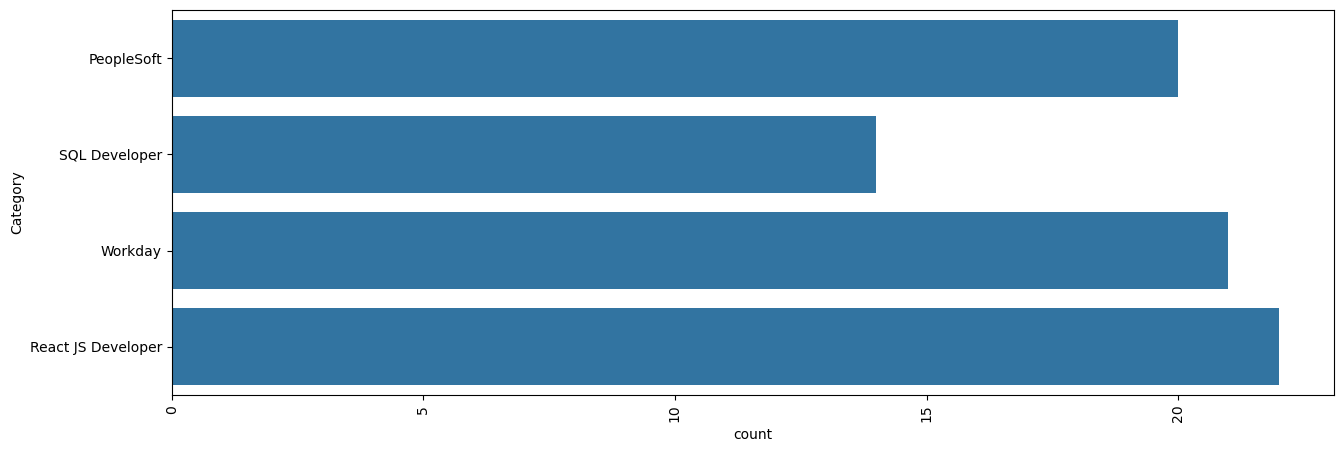

In [31]:
# Plot category distribution

plt.figure(figsize=(15,5))
sns.countplot(df['Category'])
plt.xticks(rotation=90)
plt.show()

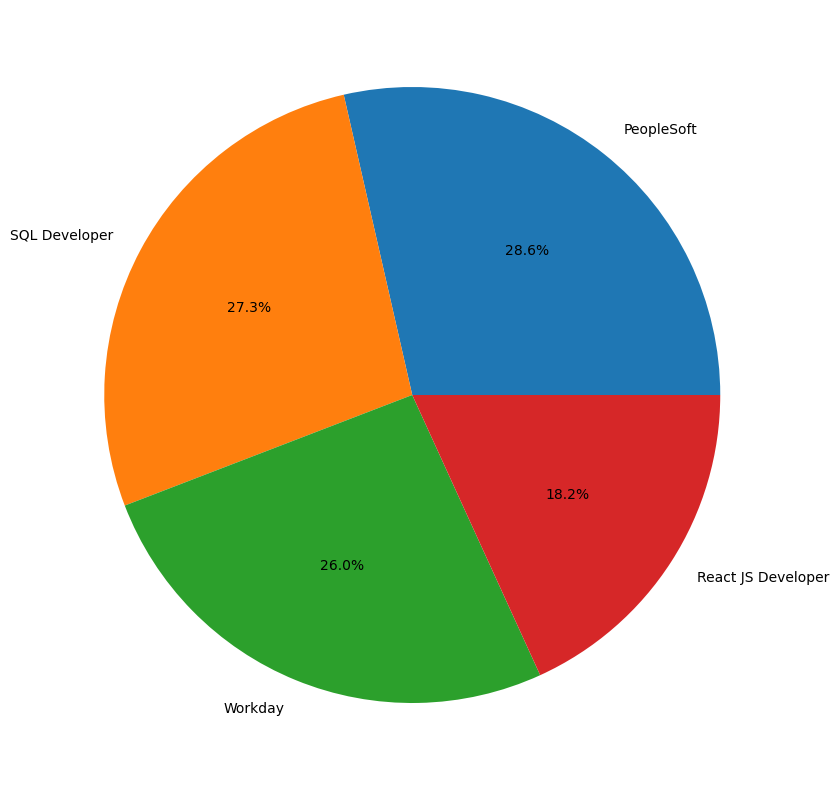

In [32]:
# Pie chart of each category

counts = df['Category'].value_counts()
labels = df['Category'].unique()
plt.figure(figsize=(15,10))

plt.pie(counts,labels=labels,autopct='%1.1f%%')
plt.show()

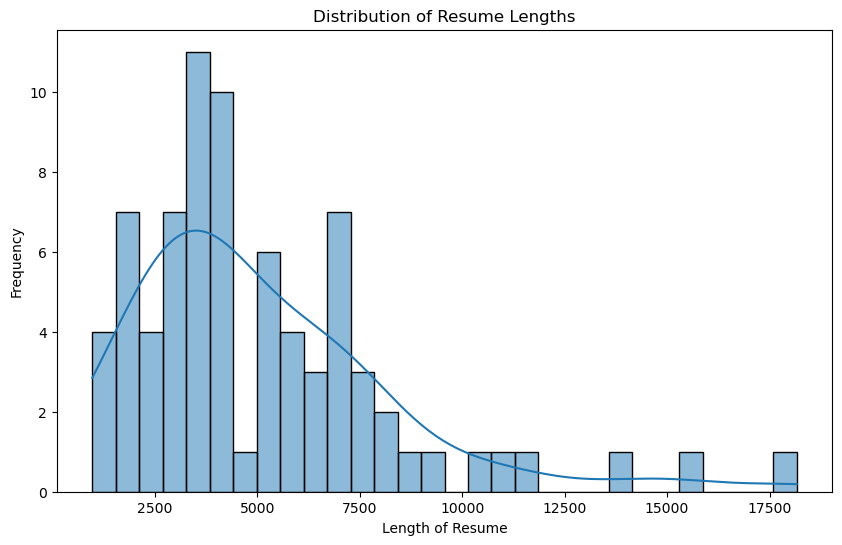

In [33]:
# Analyze the length of resumes
df['Resume_Length'] = df['Resumes'].apply(len)
plt.figure(figsize=(10, 6))
sns.histplot(df['Resume_Length'], kde=True, bins=30)
plt.title('Distribution of Resume Lengths')
plt.xlabel('Length of Resume')
plt.ylabel('Frequency')
plt.show()


#### **Word cloud to visualize common words**

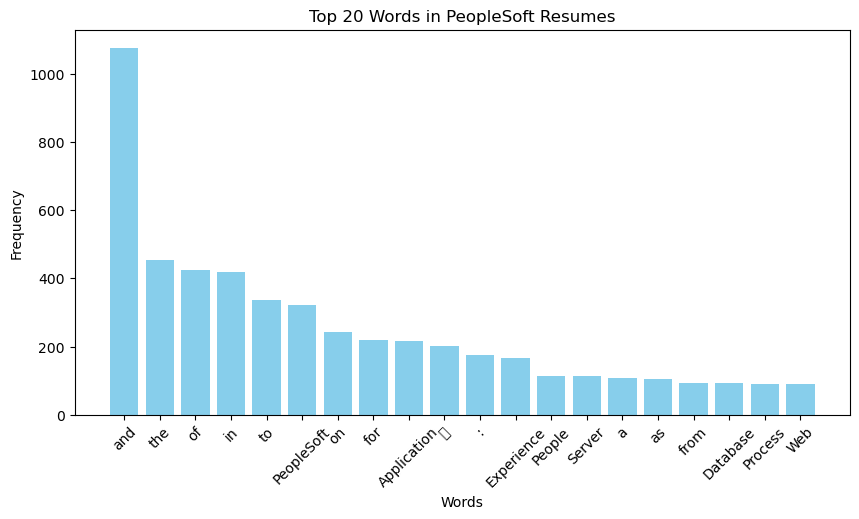

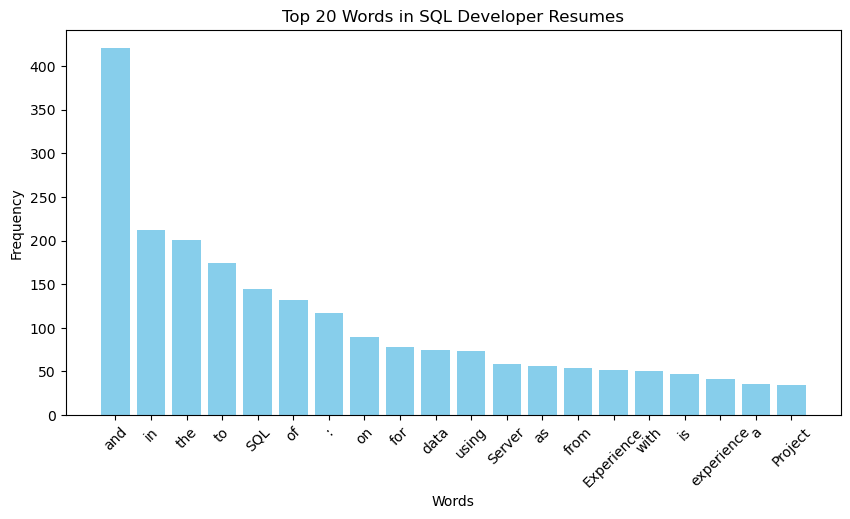

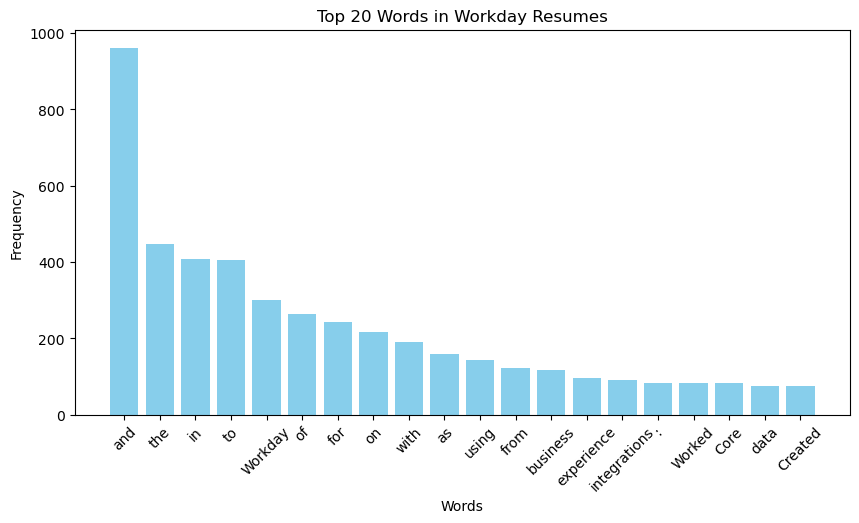

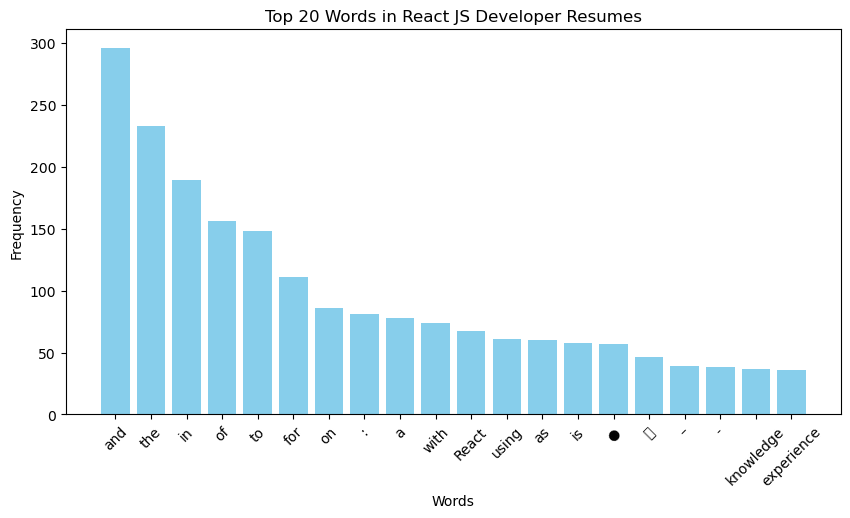

In [35]:
# Top N Words Across Categories

# Define the number of top words to display
N = 20

for category in df['Category'].unique():
    category_text = " ".join(df[df['Category'] == category]['Resumes'])
    word_freq = Counter(category_text.split())
    most_common_words = word_freq.most_common(N)

    # Plot the top N words for each category
    words, counts = zip(*most_common_words)
    plt.figure(figsize=(10, 5))
    plt.bar(words, counts, color='skyblue')
    plt.title(f"Top {N} Words in {category} Resumes")
    plt.xlabel("Words")
    plt.ylabel("Frequency")
    plt.xticks(rotation=45)
    plt.show()


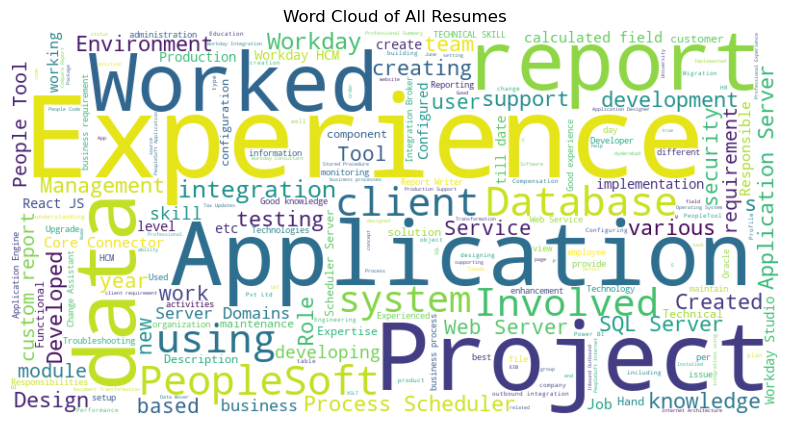

In [36]:
# Generate word cloud for all resumes
all_text = " ".join(df['Resumes'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of All Resumes")
plt.show()


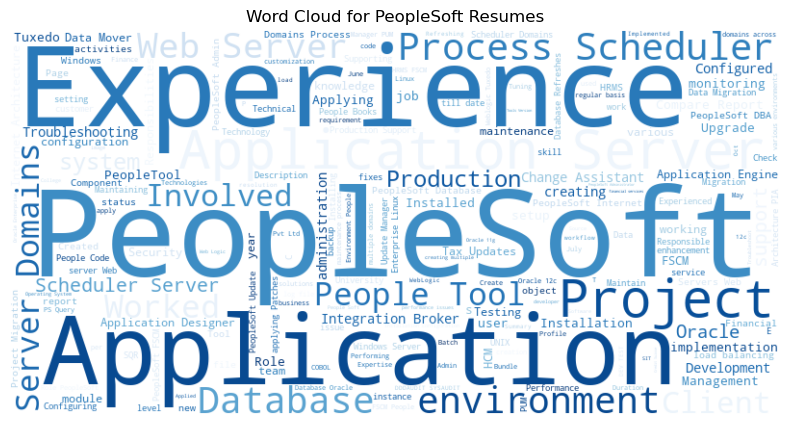

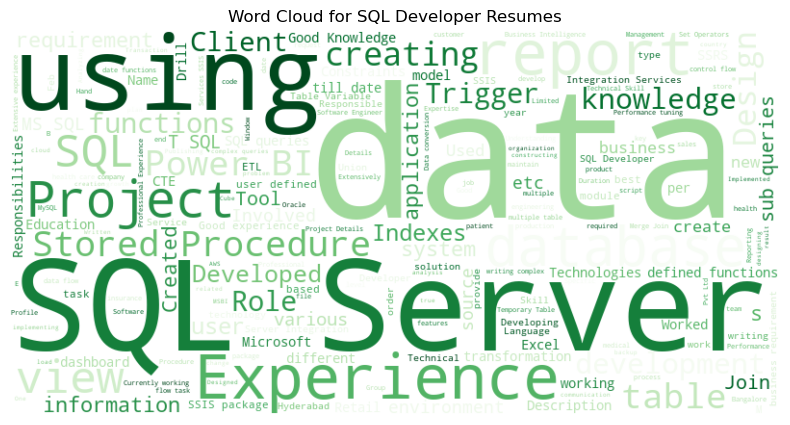

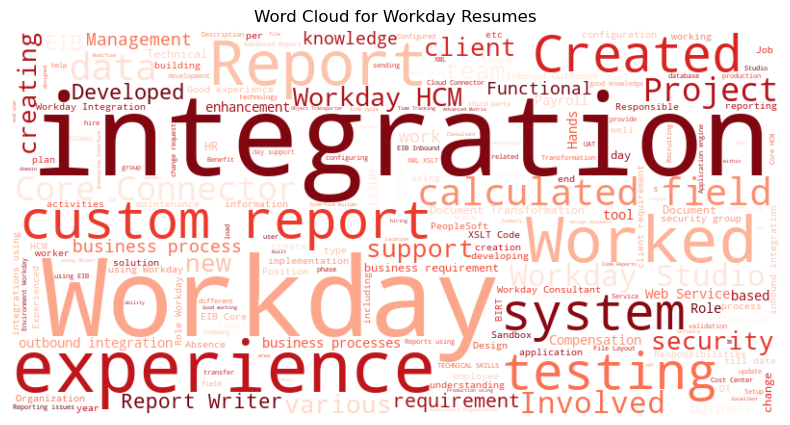

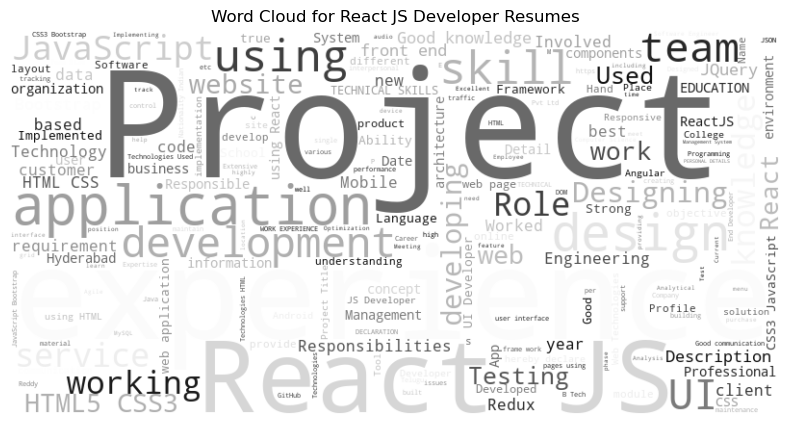

In [37]:
# Word Cloud with Category Colors

# Combine all text with categories
category_colors = {
    'PeopleSoft': 'Blues',
    'SQL Developer': 'Greens',
    'Workday': 'Reds',
    'React JS Developer': 'gray'
    # Add other categories as needed
}

for category, color in category_colors.items():
    category_text = " ".join(df[df['Category'] == category]['Resumes'])
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap=color).generate(category_text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud for {category} Resumes")
    plt.show()


#### **Statistical Analysis and Visualizations**

Word Count Statistics:
count      77.000000
mean      689.311688
std       439.635892
min       133.000000
25%       389.000000
50%       558.000000
75%       893.000000
max      2520.000000
Name: Word_Count, dtype: float64


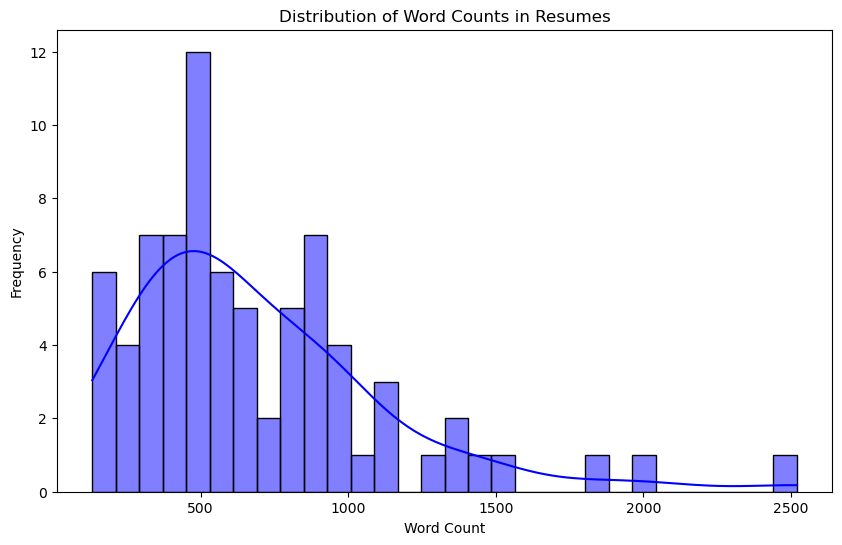

In [39]:
#  Word Count Analysis

# Calculate word count for each resume
df['Word_Count'] = df['Resumes'].apply(lambda x: len(x.split()))

# Display summary statistics for word count
print("Word Count Statistics:")
print(df['Word_Count'].describe())

plt.figure(figsize=(10, 6))
sns.histplot(df['Word_Count'], bins=30, kde=True, color='blue')
plt.title("Distribution of Word Counts in Resumes")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.show()


Unique Word Count Statistics:
count     77.000000
mean     361.181818
std      152.130807
min       99.000000
25%      253.000000
50%      340.000000
75%      481.000000
max      807.000000
Name: Unique_Word_Count, dtype: float64


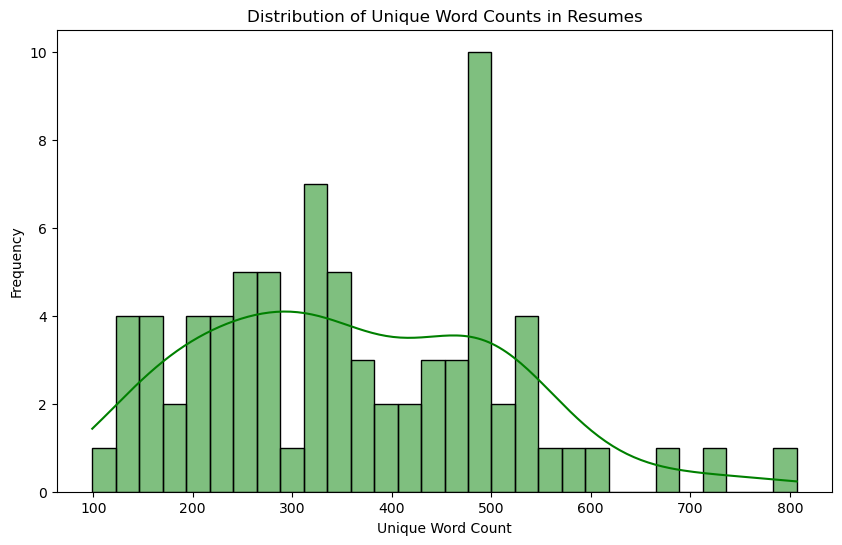

In [40]:
# Unique Word Count Analysis
# Calculate unique word count for each resume
df['Unique_Word_Count'] = df['Resumes'].apply(lambda x: len(set(x.split())))

# Display summary statistics for unique word count
print("Unique Word Count Statistics:")
print(df['Unique_Word_Count'].describe())

# Visualize unique word count distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['Unique_Word_Count'], bins=30, kde=True, color='green')
plt.title("Distribution of Unique Word Counts in Resumes")
plt.xlabel("Unique Word Count")
plt.ylabel("Frequency")
plt.show()


Stopword Ratio Statistics:
count    77.000000
mean      0.236924
std       0.033353
min       0.159091
25%       0.217087
50%       0.234649
75%       0.258730
max       0.321244
Name: Stopword_Ratio, dtype: float64


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Prathamesh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


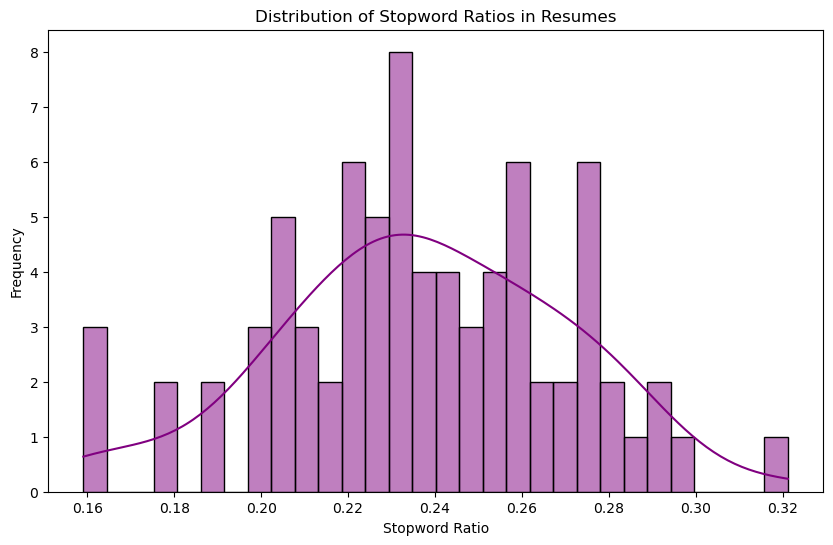

In [41]:
# Stopword Analysis

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Calculate stopword count
df['Stopword_Count'] = df['Resumes'].apply(
    lambda x: sum(1 for word in x.split() if word.lower() in stop_words)
)

# Calculate stopword ratio
df['Stopword_Ratio'] = df['Stopword_Count'] / df['Word_Count']

# Display summary statistics for stopword ratio
print("Stopword Ratio Statistics:")
print(df['Stopword_Ratio'].describe())

# Visualize stopword ratio distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['Stopword_Ratio'], bins=30, kde=True, color='purple')
plt.title("Distribution of Stopword Ratios in Resumes")
plt.xlabel("Stopword Ratio")
plt.ylabel("Frequency")
plt.show()


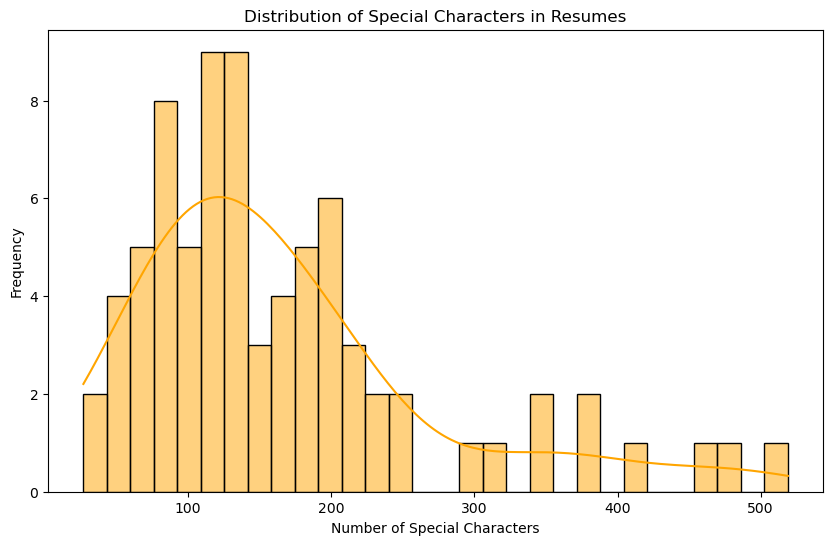

In [42]:
# Count special characters in each resume
df['Special_Char_Count'] = df['Resumes'].apply(lambda x: len(re.findall(r'[^a-zA-Z0-9\s]', x)))

# Plot the distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['Special_Char_Count'], bins=30, kde=True, color='orange')
plt.title("Distribution of Special Characters in Resumes")
plt.xlabel("Number of Special Characters")
plt.ylabel("Frequency")
plt.show()


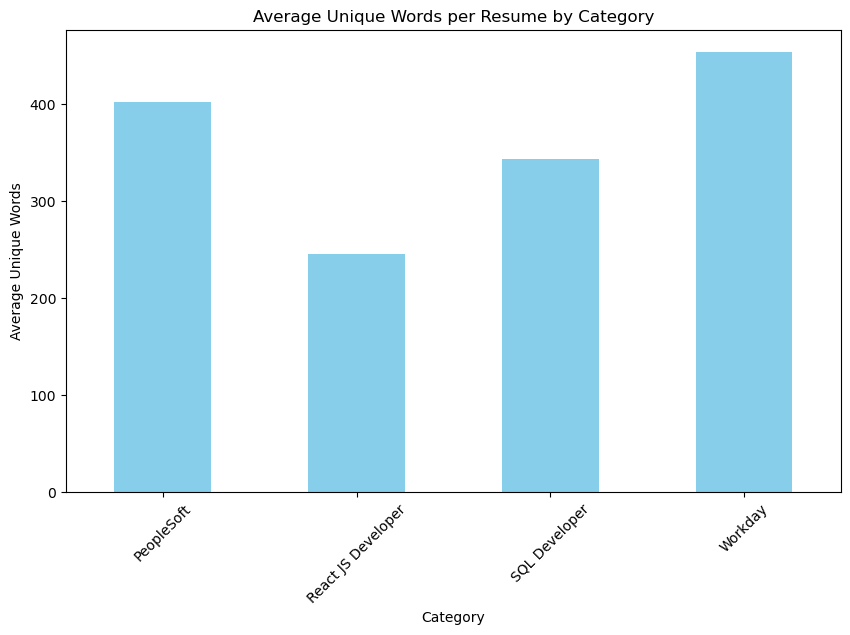

In [43]:
# Calculate the average unique word count per category
unique_word_avg = df.groupby('Category')['Unique_Word_Count'].mean()

# Plot the averages
unique_word_avg.plot(kind='bar', figsize=(10, 6), color='skyblue')
plt.title("Average Unique Words per Resume by Category")
plt.xlabel("Category")
plt.ylabel("Average Unique Words")
plt.xticks(rotation=45)
plt.show()


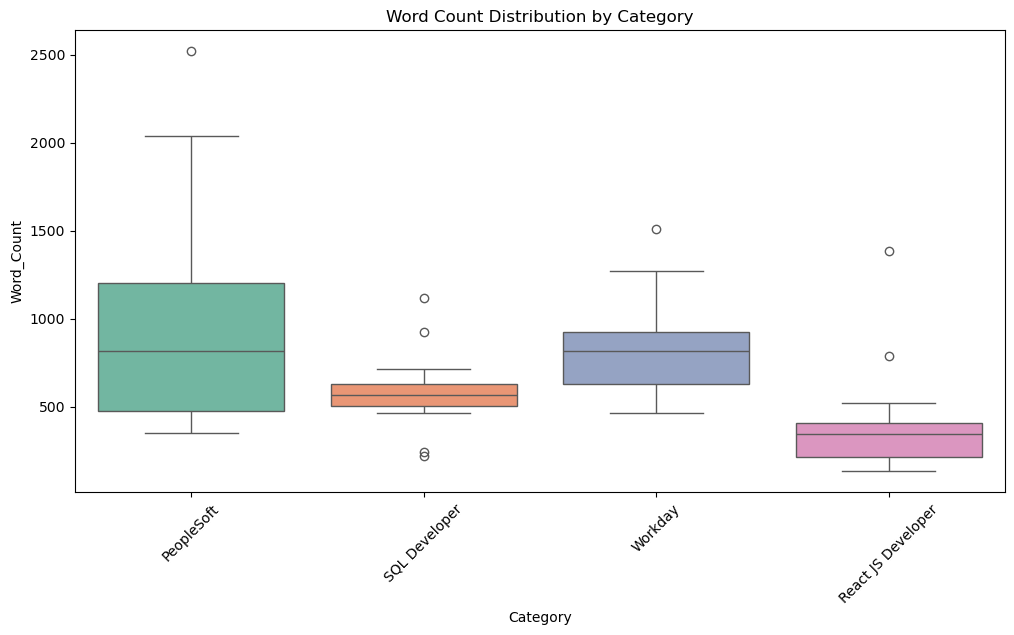

In [44]:
# Statistical Comparisons Across Categories
# Boxplot of word counts by category
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='Category', y='Word_Count', palette="Set2")
plt.title("Word Count Distribution by Category")
plt.xticks(rotation=45)
plt.show()


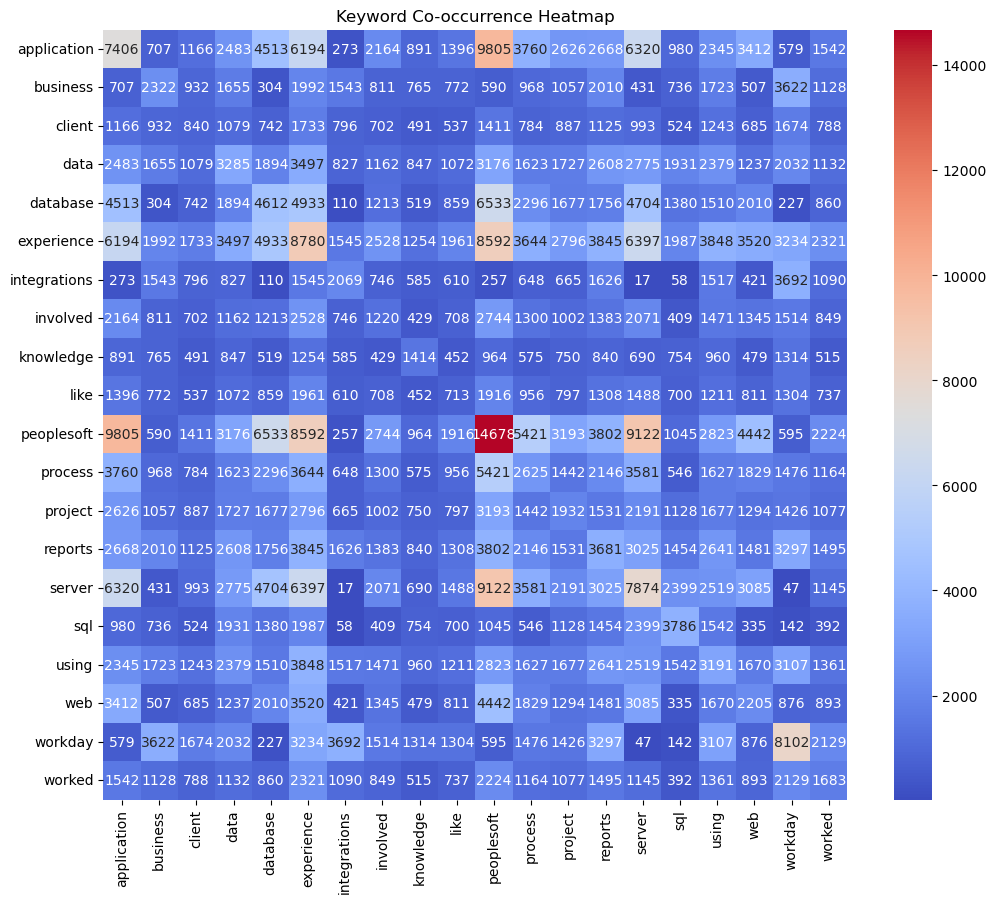

In [45]:
# Generate co-occurrence matrix for the dataset
vectorizer = CountVectorizer(max_features=20, stop_words='english')  # Limit to top 20 words
X = vectorizer.fit_transform(df['Resumes'])

# Convert to DataFrame for visualization
co_occurrence_matrix = (X.T * X).toarray()
words = vectorizer.get_feature_names_out()
co_occurrence_df = pd.DataFrame(co_occurrence_matrix, index=words, columns=words)

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(co_occurrence_df, annot=True, fmt='d', cmap='coolwarm')
plt.title("Keyword Co-occurrence Heatmap")
plt.show()


#### **Feature Engineering**

**Text Preprocessing :**

In [48]:

# Function for lemmatization with POS tagging
def lemmatize_with_pos(tokens):
    tagged_tokens = pos_tag(tokens)
    def get_wordnet_pos(tag):
        if tag.startswith('V'):
            return 'v'  # Verb
        elif tag.startswith('N'):
            return 'n'  # Noun
        elif tag.startswith('J'):
            return 'a'  # Adjective
        elif tag.startswith('R'):
            return 'r'  # Adverb
        else:
            return 'n'  # Default to noun
    return [lemmatizer.lemmatize(word, get_wordnet_pos(tag)) for word, tag in tagged_tokens]

# Preprocessing function
def cleanResume(text):
    """
    Cleans and preprocesses resume text by removing unnecessary characters, 
    tokenizing, and applying lemmatization with POS tagging.
    """
    if not isinstance(text, str):  # Ensure input is a valid string
        return ""
    
    # Convert to lowercase
    cleanText = text.lower()
    
    # Remove URLs
    cleanText = re.sub(r'http\S+\s', ' ', cleanText)
    
    # Remove retweets and unnecessary markers
    cleanText = re.sub(r'RT|cc', ' ', cleanText)
    
    # Remove hashtags and mentions
    cleanText = re.sub(r'#\S+\s', ' ', cleanText)
    cleanText = re.sub(r'@\S+', ' ', cleanText)
    
    # Remove special characters, punctuations, and non-ASCII characters
    cleanText = re.sub(r'[^a-z\s]', '', cleanText)
    cleanText = re.sub(r'[^\x00-\x7f]', ' ', cleanText)
    
    # Remove extra whitespaces
    cleanText = re.sub(r'\s+', ' ', cleanText).strip()
    
    # Tokenize text
    tokens = cleanText.split()
    
    # Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]
    
    # Lemmatize with POS tagging
    tokens = lemmatize_with_pos(tokens)
    
    # Join tokens back into a single string
    return " ".join(tokens)



* **Removed :**
    -  1. URLs                                                
    - 2. Hashtags                                             
    - 3. Mentions                                                     
    - 4. special letters                                             
    - 5. Punctuations     
* **Also, performed Tokenization and lemmitization.**

**Balanced Category Distribution**

In [52]:
# Check the original category distribution
print("Original Category Distribution:")
print(df['Category'].value_counts())

# Get the largest category size (i.e., the category with the maximum number of entries)
max_size = df['Category'].value_counts().max()

# Perform oversampling
balanced_df = df.groupby('Category').apply(lambda x: x.sample(max_size, replace=True)).reset_index(drop=True)

# Shuffle the dataset to avoid any order bias
df = balanced_df.sample(frac=1).reset_index(drop=True)

# Check the balanced category distribution
print("\nBalanced Category Distribution (After Oversampling):")
print(df['Category'].value_counts())

Original Category Distribution:
Category
React JS Developer    22
Workday               21
PeopleSoft            20
SQL Developer         14
Name: count, dtype: int64

Balanced Category Distribution (After Oversampling):
Category
React JS Developer    22
PeopleSoft            22
Workday               22
SQL Developer         22
Name: count, dtype: int64


In [53]:
# Replace NaN or non-string values with an empty string
df['Resumes'] = df['Resumes'].fillna("").astype(str)

In [54]:
# Apply the cleanResume function to each entry in the Resumes column
df['Resumes'] = df['Resumes'].apply(lambda x: cleanResume(x))

In [55]:
df['Resumes'][20]

'c n c address manyata tech park nagavara bangalore linin subhasantoshb k l l peoplesoft finance fscm ariba java full stack development sql power bi n e r e learn new technology plant hybrid specie cook travel sing r e n g h time management responsible deliverable leadership quality l n g u g e japanese french start learn sri subha santosh kumar josyula c e c n u l n p r f e n l u r year experience assistance development project like ariba peoplesoft finance su essfully complete tool patch tool upgrade project refuse validation main point contact non regression test user eptance test responsible find solution make customer satisfaction w r k e x p e r e n c e associate consultant capgemini axa june till date work module like ounts payable ounts receivable general ledger expense user profile self service uss security along application designer sql server organise customer information ount data business plan customer service purpose receive positive customer survey result work people cod

**Label Encoding**

In [57]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [58]:
le.fit(df['Category'])
df['Category'] = le.transform(df['Category'])

In [59]:
df.Category.unique()

array([1, 0, 3, 2])

**Vectorizing**

In [61]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(stop_words='english')

tfidf.fit(df['Resumes'])
requredTaxt  = tfidf.transform(df['Resumes'])

**Train-Test Split**

In [63]:
#Split dataset into Train and Test

X_train, X_test, y_train, y_test = train_test_split(requredTaxt, df['Category'], test_size=0.2, random_state=42)

print(X_train.shape)

print(X_test.shape)

(18, 3188)

**Train and Evaluate Models**

**Logistic Regression Model**

In [65]:
# # 1. Logistic Regression model

# from sklearn.linear_model import LogisticRegression
# from sklearn.model_selection import GridSearchCV, cross_val_score
# from sklearn.metrics import accuracy_score, classification_report

# print("\n=== Logistic Regression ===")

# logistic_model = OneVsRestClassifier(LogisticRegression())
# logistic_model.fit(X_train, y_train)

# # Prediction
# y_pred_train_logistic = logistic_model.predict(X_train)
# y_pred_test_logistic = logistic_model.predict(X_test)

# # Evaluation
# print("\nTraining Accuracy:", accuracy_score(y_train, y_pred_train_logistic))
# print("\nClassification Report (Training):\n", classification_report(y_train, y_pred_train_logistic))
# print("Testing Accuracy:", accuracy_score(y_test, y_pred_test_logistic))
# print("\nClassification Report (Testing):\n", classification_report(y_test, y_pred_test_logistic))


**K-Nearest Neighbor(KNN) Model**

In [67]:
# 2. K-Nearest Neighbor(KNN) Model

knn_model = OneVsRestClassifier(KNeighborsClassifier())
knn_model.fit(X_train, y_train)
# y_pred_knn = knn_model.predict(X_test)

# Prediction
y_pred_train_knn = knn_model.predict(X_train)
y_pred_test_knn = knn_model.predict(X_test)

# print("\nKNeighborsClassifier Results:")
# print(f"Accuracy: {accuracy_score(y_test, y_pred_knn):.4f}")
# print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred_knn)}")
# print(f"Classification Report:\n{classification_report(y_test, y_pred_knn)}")


# Evaluation
print("Training Accuracy (KNN):", accuracy_score(y_train, y_pred_train_knn))
print("Train Confusion Matrix:\n", confusion_matrix(y_train, y_pred_train_knn))
print("\nClassification Report (Training - KNN):\n", classification_report(y_train, y_pred_train_knn))

print("Testing Accuracy (KNN):", accuracy_score(y_test, y_pred_test_knn))
print("Test Confusion Matrix:\n", confusion_matrix(y_test, y_pred_test_knn))
print("\nClassification Report (Testing - KNN):\n", classification_report(y_test, y_pred_test_knn))


Training Accuracy (KNN): 0.9857142857142858
Train Confusion Matrix:
 [[20  0  0  0]
 [ 0 17  0  1]
 [ 0  0 17  0]
 [ 0  0  0 15]]

Classification Report (Training - KNN):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      0.94      0.97        18
           2       1.00      1.00      1.00        17
           3       0.94      1.00      0.97        15

    accuracy                           0.99        70
   macro avg       0.98      0.99      0.98        70
weighted avg       0.99      0.99      0.99        70

Testing Accuracy (KNN): 0.9444444444444444
Test Confusion Matrix:
 [[2 0 0 0]
 [0 3 0 1]
 [0 0 5 0]
 [0 0 0 7]]

Classification Report (Testing - KNN):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      0.75      0.86         4
           2       1.00      1.00      1.00         5
           3       0.88

**Support Vector Machine (SVM) Model**

In [69]:
# 3. Support Vector Machine (SVM) Model

svm_model = OneVsRestClassifier(SVC())
svm_model.fit(X_train, y_train)

y_pred_train_svm = svm_model.predict(X_train)
y_pred_test_svm = svm_model.predict(X_test)

print("\nSVM Results:")
# print(f"Accuracy: {accuracy_score(y_test, y_pred_svc):.4f}")
# print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred_svc)}")
# print(f"Classification Report:\n{classification_report(y_test, y_pred_svc)}")

# Evaluate on Train Data
print("Training Accuracy:", accuracy_score(y_train, y_pred_train_svm))
print("\nClassification Report (Training):\n", classification_report(y_train, y_pred_train_svm))

# Evaluate on Test Data
print("Testing Accuracy:", accuracy_score(y_test, y_pred_test_svm))
print("\nClassification Report (Testing):\n", classification_report(y_test, y_pred_test_svm))


SVM Results:
Training Accuracy: 1.0

Classification Report (Training):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        18
           2       1.00      1.00      1.00        17
           3       1.00      1.00      1.00        15

    accuracy                           1.00        70
   macro avg       1.00      1.00      1.00        70
weighted avg       1.00      1.00      1.00        70

Testing Accuracy: 1.0

Classification Report (Testing):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         7

    accuracy                           1.00        18
   macro avg       1.00      1.00      1.00        18
weighted avg       1.00      1.00      1.00        18



**Random Forest Model**

In [71]:
# 4. RandomForest Model

rf_model = OneVsRestClassifier(RandomForestClassifier())
rf_model.fit(X_train, y_train)


# y_pred_rf = rf_model.predict(X_test)
y_pred_train_rf = rf_model.predict(X_train)
y_pred_test_rf = rf_model.predict(X_test)

print("\nRandomForestClassifier Results:")
# print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
# print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred_rf)}")
# print(f"Classification Report:\n{classification_report(y_test, y_pred_rf)}")


print("\nTraining Accuracy:", accuracy_score(y_train, y_pred_train_rf))
print("\nClassification Report (Training):\n", classification_report(y_train, y_pred_train_rf))

print("Testing Accuracy:", accuracy_score(y_test, y_pred_test_rf))
print("\nClassification Report (Testing):\n", classification_report(y_test, y_pred_test_rf))



RandomForestClassifier Results:

Training Accuracy: 1.0

Classification Report (Training):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        18
           2       1.00      1.00      1.00        17
           3       1.00      1.00      1.00        15

    accuracy                           1.00        70
   macro avg       1.00      1.00      1.00        70
weighted avg       1.00      1.00      1.00        70

Testing Accuracy: 1.0

Classification Report (Testing):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         7

    accuracy                           1.00        18
   macro avg       1.00      1.00      1.00        18
weighted avg       1.00      1.00  

**LightGBM (Light Gradient Boosting Machine)**

In [73]:
# # 5. Light Gradient Boosting Machine(LightGBM)) model

# print("\n=== LGBM ===")

# # LGBM with Regularization
# lgbm_model = OneVsRestClassifier(LGBMClassifier())
# lgbm_model.fit(X_train, y_train)

# # Prediction
# y_pred_train_lgbm = lgbm_model.predict(X_train)
# y_pred_test_lgbm = lgbm_model.predict(X_test)

# # Evaluation
# print("\nTraining Accuracy:", accuracy_score(y_train, y_pred_train_lgbm))
# print("\nClassification Report (Training):\n", classification_report(y_train, y_pred_train_lgbm))
# print("\nTesting Accuracy:", accuracy_score(y_test, y_pred_test_lgbm))
# print("\nClassification Report (Testing):\n", classification_report(y_test, y_pred_test_lgbm))

**Compare Models**

In [75]:

# Model Comparison using existing predictions
results = pd.DataFrame({
    'Model': ['KNN', 'SVM', 'Random Forest'],  # 'Logistic Regression', 'LGBM'
    'Train Accuracy': [
        # accuracy_score(y_train, y_pred_train_logistic),        # Logistic Regression
        accuracy_score(y_train, y_pred_train_knn),             # KNN
        accuracy_score(y_train, y_pred_train_svm),             # SVM
        accuracy_score(y_train, y_pred_train_rf),              # Random Forest
        # accuracy_score(y_train, y_pred_train_lgbm)             # LightGBM
    ],
    'Test Accuracy': [
        # accuracy_score(y_test, y_pred_test_logistic),          # Logistic Regression
        accuracy_score(y_test, y_pred_test_knn),               # KNN
        accuracy_score(y_test, y_pred_test_svm),               # SVM
        accuracy_score(y_test, y_pred_test_rf),                # Random Forest
        # accuracy_score(y_test, y_pred_test_lgbm)               # LightGBM
    ]
})

# Optional: Sort by Test Accuracy
results = results.sort_values(by='Test Accuracy')

print("\n=== Model Comparison ===")
print(results)



=== Model Comparison ===
           Model  Train Accuracy  Test Accuracy
0            KNN        0.985714       0.944444
1            SVM        1.000000       1.000000
2  Random Forest        1.000000       1.000000


**Prediction System**

In [119]:

# Function to predict the category of a resume
def pred(input_resume):
    # Preprocess the input text (e.g., cleaning, etc.)
    cleaned_text = cleanResume(input_resume) 

    # Vectorize the cleaned text using the same TF-IDF vectorizer used during training
    vectorized_text = tfidf.transform([cleaned_text])
    
    # Convert sparse matrix to dense
    vectorized_text = vectorized_text.toarray()

    # Prediction
    predicted_category = knn_model.predict(vectorized_text)

    # get name of predicted category
    predicted_category_name = le.inverse_transform(predicted_category)

    return predicted_category_name[0]  # Return the category name


In [121]:
myresume = """
Jane Doe
Contact: janedoe@example.com | +1-234-567-89026
Location: Los Angeles, CA

Objective
Proficient React.js developer with expertise in modern front-end frameworks.
Work Experience
- Developed dynamic single-page applications using React.js.
- Implemented responsive designs for web applications.
Skills
React.js, Redux
Education
MBA
Certifications
React Professional Certificate
References
Available upon request.
"""

# Now, test the model with the React JS Developer resume
pred(myresume)


'React JS Developer'

In [123]:
myresume = """
Michael White
Contact: michaelwhite@example.com | +1-234-567-89012
Location: New York, NY

Objective
Skilled PeopleSoft consultant specializing in HCM and Payroll systems.
Work Experience
- Provided user training sessions and documentation.
- Automated payroll workflows, improving efficiency by 35%.
Skills
SQR, PeopleTools
Education
MBA
Certifications
Certified PeopleSoft Consultant
References
Available upon request.
"""

# Now, test the model with the PeopleSoft resume
pred(myresume)

'PeopleSoft'

In [125]:
myresume = """
Chris Brown
Contact: chrisbrown@example.com | +1-234-567-89020
Location: Chicago, IL

Objective
Workday consultant with expertise in HCM and financial systems.
Work Experience
- Led integrations with third-party applications.
- Designed and delivered custom Workday dashboards.
Skills
Integration Tools, Payroll Systems
Education
Bachelor's in Computer Science
Certifications
HCM Functional Consultant
References
Available upon request.
"""

# Now, test the model with the Workday resume
pred(myresume)


'Workday'

In [127]:
myresume = """
John Smith
Contact: johnsmith@example.com | +1-234-567-89024
Location: New York, NY

Objective
Experienced SQL developer skilled in database optimization and management.
Work Experience
- Designed and optimized SQL queries for enterprise databases.
- Implemented stored procedures for data processing.
Skills
Data Modeling, T-SQL
Education
MBA
Certifications
Microsoft Certified: Azure Database Administrator
References
Available upon request.
"""

# Now, test the model with the SQL Developer resume
pred(myresume)


'SQL Developer'

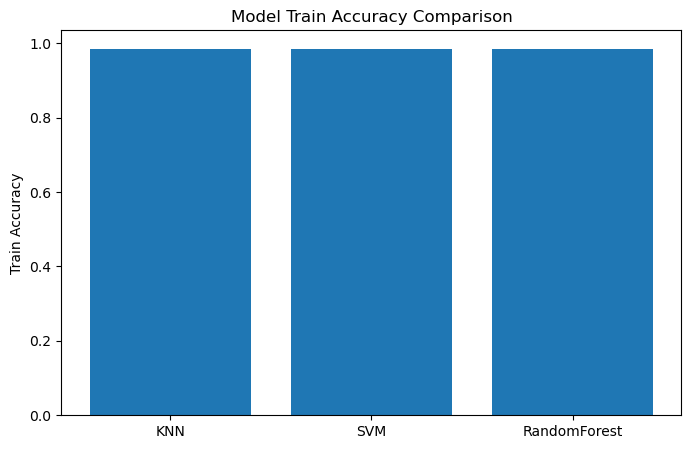

In [129]:
# Comparative Evaluation of Models
models = {'KNN': knn_model, 'SVM': svm_model, 'RandomForest': rf_model}
results = {}
for model_name, model in models.items():
    y_pred = model.predict(X_test)
    results[model_name] = {
        'Train Accuracy': accuracy_score(y_train, y_pred_train_knn),
        'Test Accuracy': accuracy_score(y_test, y_pred_test_knn),
        'Train Classification Report': classification_report(y_train, y_pred_train_knn, output_dict=True),
        'Test Classification Report': classification_report(y_test, y_pred_test_knn, output_dict=True)
    }
# Visualize Train Accuracy comparison
accuracies = [results[m]['Train Accuracy'] for m in models]
plt.figure(figsize=(8, 5))
plt.bar(models.keys(), accuracies)
plt.title('Model Train Accuracy Comparison')
plt.ylabel('Train Accuracy')
plt.show()


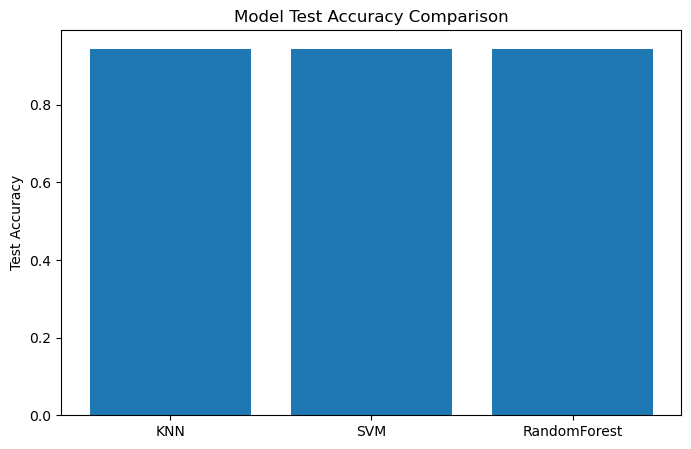

In [131]:
# Visualize Test Accuracy comparison
accuracies = [results[m]['Test Accuracy'] for m in models]
plt.figure(figsize=(8, 5))
plt.bar(models.keys(), accuracies)
plt.title('Model Test Accuracy Comparison')
plt.ylabel('Test Accuracy')
plt.show()

In [133]:
# Cross-validation to ensure robustness
from sklearn.model_selection import cross_val_score
for model_name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=5)
    print(f'{model_name} Cross-Validation Accuracy: {scores.mean():.4f}')


KNN Cross-Validation Accuracy: 0.9857
SVM Cross-Validation Accuracy: 0.9857
RandomForest Cross-Validation Accuracy: 0.9857


In [135]:
# Save the LabelEncoder to a pickle file
pickle_file_path = "le.pkl"
with open(pickle_file_path, 'wb') as file:
    pickle.dump(le, file)

In [137]:
# Save the vectorizer to a pickle file
pickle_file_path = "tfidf_vectorizer.pkl"
with open(pickle_file_path, 'wb') as file:
    pickle.dump(vectorizer, file)

In [139]:
# Save the KNN model to a pickle file
pickle_file_path = "knn_model.pkl"
with open(pickle_file_path, 'wb') as file:
    pickle.dump(knn_model, file)